# Guía 1 - Ejercicio 3 

## Imports y definición de funciones 

In [15]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

La función ventana_trackbars toma como argumentos parámetros de las trackbars como son el nombre y el rango de cada variable, y una función que va a ser aplicada a la imagen para obtener una imagen transformada. Esta se muestra a la derecha de la imagen original y permite ir ajustando los valores de las variables mediante las trackbars para obtener los valores deseados

In [16]:
def evitar_desborde(imagen):

    minimo = np.min(imagen)
    maximo = np.max(imagen)

    if minimo < 0:
        imagen = imagen + 255
        imagen = imagen / 2
    if maximo > 255:
        imagen = (imagen - minimo)*(255/(maximo-minimo))
    
    return imagen
def nothing(x): #Función dummy para las trackbars (no se a quien se le ocurrió que debe ser así)
    pass
def ventana_trackbars(imagen, variables_trackbar = None, parametros_trackbar = None, transformacion = None):
  #Validaciones pavas
  if variables_trackbar:
      if parametros_trackbar:
          if len(variables_trackbar) != len(parametros_trackbar):
              print("Trackbars y parámetros debe tener el mismo tamaño")
              return
      else:
          print("Si hay trackbars tienen que haber parámetros")
          return
  
  # Defino ventana y sus trackbars correspondientes
  NOMBRE_VENTANA = "IMAGEN_y_TRANSFORMADA"
  cv.namedWindow(NOMBRE_VENTANA)

  for i in range(len(variables_trackbar)):
    bordes = parametros_trackbar[i]
    cv.createTrackbar(variables_trackbar[i], NOMBRE_VENTANA,bordes[0],bordes[1],nothing)
  imagen_original = imagen.copy()
  while True:

    valores_trackbars = []
    for i in range(len(variables_trackbar)):
        valores_trackbars.append(cv.getTrackbarPos(variables_trackbar[i], NOMBRE_VENTANA))
    
    imagen_salida = evitar_desborde(transformacion(imagen, valores_trackbars))
    # if imagen_salida.shape != imagen.shape:
    #     imagen_original = cv.cvtColor(imagen,cv.COLOR_GRAY2BGR)

    imagen_combinada = np.concatenate((imagen_original,imagen_salida),axis=1)
    
    cv.imshow(NOMBRE_VENTANA,imagen_combinada)
        
    k = cv.waitKey(1) & 0xFF
    if k == 27:
      break
  cv.destroyAllWindows()


La función segmentacion_hsv toma como argumento una imagen, el rango de hue y el rango de saturación y genera una máscara con los valores dentro de ese rango. Realiza un and para quedarme con los valores que cumplan con ambas condiciones, posteriormente aplica la máscara a la imagen y pinta de rojo como es pedido en el ejercicio. Luego genera una imagen en la variable resultado con la imagen más la segmentación.

In [17]:
def segmentacion_hsv(imagen, rango_hue, rango_saturation):

    imagen_hsv = cv.cvtColor(imagen, cv.COLOR_BGR2HSV)
    
    h, s, _ = cv.split(imagen_hsv)
    
    mascara = np.logical_and(
        np.logical_and(rango_hue[0] <= h, h <= rango_hue[1]),
        np.logical_and(rango_saturation[0] <= s, s <= rango_saturation[1])
    )
    
    mascara = np.uint8(mascara * 255)  # Convertimos la máscara a tipo uint8
    
    segmentacion = cv.bitwise_and(imagen, imagen, mask=mascara)
    segmentacion[np.where((segmentacion!=[0,0,0]).all(axis=2))] = [0,0,255]  # Pintamos en rojo
    
    mascara_inversa = cv.bitwise_not(mascara)
    area_no_segmentada = cv.bitwise_and(imagen, imagen, mask=mascara_inversa)
    
    resultado = cv.add(segmentacion, area_no_segmentada)
    
    return resultado, segmentacion

De forma similar, segmentación_hsv_trackbar es la versión de la función anterior para poder visuarlizarla en una ventana con trackbars

In [18]:
def segmentacion_hsv_trackbar(imagen, valores_trackbar):
    rango_hue = [valores_trackbar[0], valores_trackbar[1]]
    rango_saturation = [valores_trackbar[2], valores_trackbar[3]]
    rango_value = [valores_trackbar[4], valores_trackbar[5]]
    
    imagen_hsv = cv.cvtColor(imagen, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(imagen_hsv)

    mascara = np.logical_and(
        np.logical_and(rango_hue[0] <= h, h <= rango_hue[1]),
        np.logical_and(rango_saturation[0] <= s, s <= rango_saturation[1]),
        np.logical_and(rango_value[0] <= v, v <= rango_value[1])
    )
    
    mascara = np.uint8(mascara * 255)  # Convertimos la máscara a tipo uint8
    
    # Pintamos el área segmentada en rojo
    segmentacion = cv.bitwise_and(imagen, imagen, mask=mascara)
    segmentacion[np.where((segmentacion!=[0,0,0]).all(axis=2))] = [0,0,255]  # Pintamos en rojo
    
    # Convertimos la máscara a un formato donde el área segmentada sea blanca y el resto negro
    mascara_inversa = cv.bitwise_not(mascara)
    area_no_segmentada = cv.bitwise_and(imagen, imagen, mask=mascara_inversa)
    
    # Combinamos el área segmentada en rojo con el resto de la imagen
    resultado = cv.add(segmentacion, area_no_segmentada)
    
    return resultado

Segmentacion_RGB es la función que nos permite realizar la segmentación en el espacio RGB, finalmente no terminamos usándola porque creímos que era más conveniente realizar la segmentación en el espacio hsv enfocandonos en la saturación y el tono de los verdes.

In [19]:


def segmentacion_RGB(imagen, color, radio, color_dentro_radio = None, color_fuera_radio = None):
    imagen_rgb = cv.cvtColor(imagen, cv.COLOR_BGR2RGB)
    
    centroide = np.array(color)
    distancias = np.linalg.norm(imagen_rgb - centroide, axis=-1)

    mascara_rgb = np.where(distancias <= radio, 1, 0).astype(np.uint8)

    if color_dentro_radio is None or color_fuera_radio is None: 
        color_dentro_radio = (255,0,0) #Rojo
        color_fuera_radio = (0,0,0) 
    
    imagen_rgb_segmentada = np.where(mascara_rgb[...,None], color_dentro_radio, color_fuera_radio)
    
    mascara_rgb = np.where(distancias <= radio, 255, 0).astype(np.uint8) #Donde las distancias sean <= radio 1 sino 0)
    
    imagen_rgb_segmentada = cv.bitwise_and(imagen_rgb, imagen_rgb, mask=mascara_rgb)
    
    return imagen_rgb_segmentada



## Lectura de la imagen y pre-procesamiento

Se comienza el ejercicio leyendo la imagen, mostrándola y a partir de esto, tomando la región delimitada (x0,y0) a (x1,y1). Posteriormente, se le aplica un pre-procesamiento a la imagen. Aplicando un filtro de promediado para homogeneizar las zonas, puesto que de no hacerlo al segmentar aparecían píxeles segmentados que no corresponden a la zona deforestada. El tamaño de máscara fue creciendo hasta obtener una segmentación lo suficientemente buena (subjetivamente).

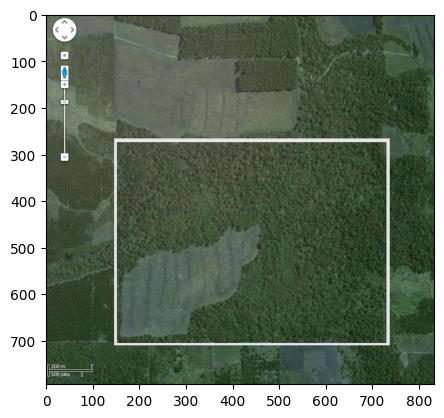

In [20]:

ruta = "Imagenes_Ej/Deforestacion.png"
imagen = cv.imread(ruta)

plt.imshow(imagen)
plt.show()

x0 = 153
y0 = 274
x1 = 728
y1 = 703
imagen_delimitada = imagen[y0:y1,x0:x1].copy()

# Pre-procesamiento para hacer más facil la segmentacion
sizeMascara = 18
mascara_promedio = np.ones((sizeMascara, sizeMascara), np.float32) / (sizeMascara**2)
#Median blur
imagen_delimitada_preprocesada = cv.filter2D(imagen_delimitada, -1, mascara_promedio)

En el siguiente bloque de código se realiza la llamada a la función de ventana_trackbars previamente explicada, donde se ve como se definen sus argumentos y se la llama. Al ejecutar debe aparecer una ventana flotante.

In [21]:
# Trackbar
variables_trackbar = ['hue0', 'hue1', 'saturation0', 'saturation1','value0','value1']
parametros_trackbar = [[0,360],[0,360],[0,255],[0,255],[0,255],[0,255]]

# Obtención de parámetros a través de la prueba de valores con trackbars
ventana_trackbars(imagen_delimitada_preprocesada, 
                variables_trackbar = variables_trackbar, 
                parametros_trackbar = parametros_trackbar, 
                transformacion = segmentacion_hsv_trackbar)



## Segmente y resalte en algún tono de rojo el área deforestada 
A partir de la prueba de diferentes valores con la funcíon ventana_trackbars se eligen los siguientes rangos de valores y se realiza la segmentación con ellos. Después, se muestra la imagen con la segmentación de color rojo por encima.

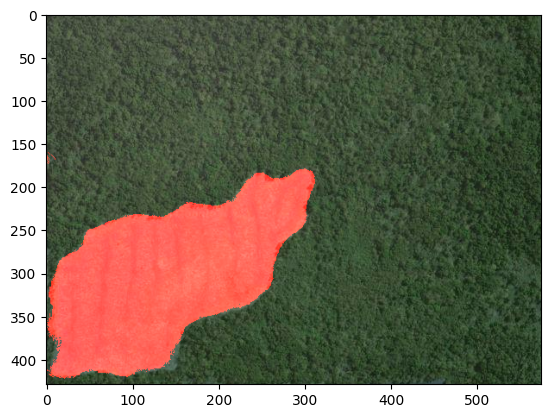

In [22]:
rango_hue = [0, 67] #Valores obtenidos a través de vista de trackbars
rango_saturation = [0, 55]
imagen_delimitada_segmentada, segmentacion = segmentacion_hsv(imagen_delimitada_preprocesada, rango_hue, rango_saturation)

segmentacion = cv.cvtColor(segmentacion,cv.COLOR_BGR2RGB)
imagen_delimitada_final = cv.add(imagen_delimitada, segmentacion)
plt.imshow(imagen_delimitada_final)

plt.show()



## Cálculo del área total de la zona delimitada, área de zona con monte y área de zona deforestada
Aquí se define la función calcular_area que recibe la imagen de la zona delimitada, la segmentación y la relación entre el píxel de la imagen y los metros reales. Esta relación se obtiene usando la escala de la esquina inferior izquierda de referencia, donde 100 unidades de la imagen corresponden a 200 m, por lo tanto, 1 unidad de la imagen corresponde a 2 metros. Se obtiene el área total, luego el área segmentada (contando los valores no ceros) y, finalmente, el área de monte como la resta entre el área total y el área desforestada.

In [23]:
def calcular_area(imagen_total, imagen_segmentada, unidad_imagen_a_metros):

    ancho_imagen = imagen_total.shape[1] 
    alto_imagen = imagen_total.shape[0]   
    area_total_pixeles = ancho_imagen * alto_imagen #Está en píxeles cuadrados  
    area_total_metros_cuadrados = area_total_pixeles * (unidad_imagen_a_metros ** 2)  #Multiplico por el factor de escala al cuadrado
    
    area_segmentada_pixeles = np.sum(imagen_segmentada != 0)  
    area_segmentada_metros_cuadrados = area_segmentada_pixeles * (unidad_imagen_a_metros ** 2)  
    
    area_no_segmentada_metros_cuadrados = area_total_metros_cuadrados - area_segmentada_metros_cuadrados
    
    return area_segmentada_metros_cuadrados, area_no_segmentada_metros_cuadrados, area_total_metros_cuadrados

unidad_imagen_a_metros = 200/100

area_deforestada, area_monte, area_total = calcular_area(imagen_delimitada, segmentacion, unidad_imagen_a_metros)

print("Area deforestada", area_deforestada) 

print("Area monte", area_monte) 

print("Area total", area_total) 

Area deforestada 169332.0
Area monte 817368.0
Area total 986700.0
